In [22]:
import numpy as np
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
from IPython.display import display
from typing import List, Callable
import seaborn as sns

# 데이터 과학 입문 Project

---
## 1. Data 준비

### 0) Preprocess
#### remove [tap, space, symbols]

In [23]:
def preprocess_data(file:str , functions:List[Callable]=None) -> None:
    """
        read file and replace the text lines through functions.
    """
    with open(file, 'r', encoding='cp949') as f:
        lines = f.readlines()
        new_lines = []
        for line in lines:
            for func in functions:
                line = func(line)
            new_lines.append(line)

    with open(file, 'w', encoding='cp949') as f:
        f.writelines(new_lines)

def remove_tap(text):
    return text.replace('\t','')

def remove_space(text):
    return text.strip()

def remove_symbol(text): # except ',' symbol
    return re.sub('[^A-Za-z0-9가-힣,.]', '', text)

def add_enter(text):
    return text + '\n'

for file_name in ['강수량', '기온', '습도', '일조량', '풍속', '소매업태별_판매액지수', '업태별상품군_판매액지수']:
    preprocess_data(f'./data/{file_name}.csv', [remove_tap,
                                                remove_space,
                                                remove_symbol,
                                                add_enter])

### 1) Weather data
- csv 파일 불러오기

In [24]:
# 파일 불러오기
temp_df = pd.read_csv('./data/기온.csv', encoding='cp949')
rainfall_df = pd.read_csv('./data/강수량.csv', encoding='cp949')
windspeed_df = pd.read_csv('./data/풍속.csv', encoding='cp949')
humidity_df = pd.read_csv('./data/습도.csv', encoding='cp949')
sunlight_df = pd.read_csv('./data/일조량.csv', encoding='cp949')

# 파일 합치기
weather_df = temp_df.merge(rainfall_df).merge(windspeed_df).merge(humidity_df).merge(sunlight_df)
display(weather_df.head())

,지점번호,지점명,일시,평균기온,평균최고기온,최고기온,최고기온일자,평균최저기온,최저기온,최저기온일자,...,최대풍속일자,최대순간풍속ms,최대순간풍속풍향deg,최대순간풍속일자,Unnamed: 10,평균습도rh,최저습도rh,일조합,일조율,일사합
0,108.0,서울,Jan00,21.0,17.0,99.0,20000101.0,57.0,121.0,20000107.0,...,20000102.0,123.0,290.0,20000130.0,NaN,64.0,28.0,1083.0,3533.0,13093.0
1,108.0,서울,Feb00,17.0,26.0,75.0,20000219.0,58.0,116.0,20000201.0,...,20000227.0,191.0,230.0,20000227.0,NaN,56.0,27.0,1393.0,445.0,28938.0
2,108.0,서울,Mar00,63.0,114.0,189.0,20000327.0,17.0,48.0,20000308.0,...,20000327.0,199.0,230.0,20000327.0,NaN,55.0,23.0,1528.0,4119.0,3895.0
3,108.0,서울,Apr00,119.0,169.0,235.0,20000420.0,73.0,18.0,20000411.0,...,20000410.0,188.0,290.0,20000410.0,NaN,56.0,26.0,1566.0,3961.0,4409.0
4,108.0,서울,May00,175.0,227.0,305.0,20000525.0,129.0,79.0,20000502.0,...,20000507.0,136.0,230.0,20000528.0,NaN,66.0,26.0,1383.0,3142.0,44369.0


- 컬럼 선택

In [25]:
print(f"available attribute : {list(weather_df.columns)}")

# 사용할 컬럼 선택
weather_columns = ["일시", "평균기온", "강수량mm", "평균풍속ms", "평균습도rh","일조합"]
selected_weather_df = weather_df[weather_columns].dropna()

# 일시 format 변경 (ex :Jan00 -> 2000-01 )
month_eng = {mon:i for i,mon in
             enumerate(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul","Aug","Sep","Oct","Nov","Dec"])}
selected_weather_df['일시'] = selected_weather_df['일시'].apply(lambda x:f"20{x[3:]}-{month_eng[x[0:3]]:02d}")

display(selected_weather_df)

available attribute : ['지점번호', '지점명', '일시', '평균기온', '평균최고기온', '최고기온', '최고기온일자', '평균최저기온', '최저기온', '최저기온일자', '강수량mm', '일최다강수량mm', '일최다강수량일자', '1시간최다강수량mm', '1시간최다강수량일자', '평균풍속ms', '최대풍속ms', '최대풍속풍향deg', '최대풍속일자', '최대순간풍속ms', '최대순간풍속풍향deg', '최대순간풍속일자', 'Unnamed: 10', '평균습도rh', '최저습도rh', '일조합', '일조율', '일사합']


,일시,평균기온,강수량mm,평균풍속ms,평균습도rh,일조합
0,2000-00,21.0,428.0,26.0,64.0,1083.0
1,2000-01,17.0,21.0,27.0,56.0,1393.0
2,2000-02,63.0,31.0,3.0,55.0,1528.0
3,2000-03,119.0,307.0,29.0,56.0,1566.0
4,2000-04,175.0,752.0,23.0,66.0,1383.0
...,...,...,...,...,...,...
263,2021-11,6.0,79.0,23.0,62.0,1854.0
264,2022-00,22.0,55.0,22.0,55.0,2069.0
265,2022-01,11.0,47.0,26.0,55.0,2038.0
266,2022-02,77.0,1026.0,25.0,62.0,173.0


### 2) 소매업태 별 판매량
- 파일 불러오기

In [26]:
retails_df = pd.read_csv('./data/소매업태별_판매액지수.csv', encoding='cp949', index_col=0).T

retails_df['일시'] = retails_df.index
display(retails_df.head(2))

print(retails_df.index)

,업태별,총지수,백화점,대형마트,면세점,슈퍼마켓및잡화점,체인슈퍼마켓,일반슈퍼마켓및잡화점,편의점,승용차및연료소매점,...,전문소매점,가전컴퓨터통신기기소매점,의복신발가방소매점,음식가정문화상품소매점,의약품화장품기타상품소매점,무점포소매,인터넷쇼핑,홈쇼핑,방문및배달소매점,일시
1995.01,경상지수,32,49.5,NaN,NaN,42.9,NaN,NaN,4.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995.01
1995.01.1,불변지수,49.8,86.1,NaN,NaN,92.5,NaN,NaN,11.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995.01.1


Index(['1995.01', '1995.01.1', '1995.01.2', '1995.02', '1995.02.1',
       '1995.02.2', '1995.03', '1995.03.1', '1995.03.2', '1995.04',
       ...
       '2021.12.2', '2022.01', '2022.01.1', '2022.01.2', '2022.02p',
       '2022.02p.1', '2022.02p.2', '2022.03p', '2022.03p.1', '2022.03p.2'],
      dtype='object', length=981)


- 지수 종류 및 column 선택
  - 지수 종류 [경상지수, 불변지수, 계절조정지수]

In [27]:
print(f"available attribute : {list(retails_df.columns)}")
retail_sales_type = '경상지수'
retails_columns = ['백화점','편의점','인터넷쇼핑']
selected_retails_df = retails_df[retails_df['업태별']==retail_sales_type][retails_columns].dropna()

# index 변경 (일시 데이터 컬럼 생성 및 format 변환)
selected_retails_df['일시'] = selected_retails_df.index.map(lambda x:f"{x[0:4]}-{x[5:7]}")
selected_retails_df = selected_retails_df.reset_index(drop=True)

display(selected_retails_df.head())

available attribute : ['업태별', '총지수', '백화점', '대형마트', '면세점', '슈퍼마켓및잡화점', '체인슈퍼마켓', '일반슈퍼마켓및잡화점', '편의점', '승용차및연료소매점', '승용차소매점', '연료소매점', '전문소매점', '가전컴퓨터통신기기소매점', '의복신발가방소매점', '음식가정문화상품소매점', '의약품화장품기타상품소매점', '무점포소매', '인터넷쇼핑', '홈쇼핑', '방문및배달소매점', '일시']


,백화점,편의점,인터넷쇼핑,일시
0,56.6,6.8,3,2000-01
1,44,6.6,3.1,2000-02
2,50.4,7.1,3.3,2000-03
3,61.5,7.4,3.2,2000-04
4,51.5,8,3.4,2000-05


### 3) 상품군별_판매액지수
- 파일 불러오기

In [28]:
product_df = pd.read_csv('./data/재별및상품군별_판매액지수.csv', encoding='cp949', index_col=0).T
product_df.columns = [product_df.columns, product_df.loc['항목']]  # multi column으로 변경 (상품군 , 지수종류)
product_df = product_df.drop(index=['항목','단위'])

display(product_df.head())

총지수              총지수(승용차 제외)               내구재                승용차  \
항목         경상지수  불변지수 계절조정지수        경상지수 불변지수 계절조정지수  경상지수  불변지수 계절조정지수  경상지수   
1995.01 월  32.0  49.8   48.9         NaN  NaN    NaN  44.7  30.0   34.5  28.6   
1995.02 월  27.2  42.1   46.0         NaN  NaN    NaN  40.0  27.0   33.9  23.3   
1995.03 월  30.2  46.4   46.3         NaN  NaN    NaN  46.8  31.4   34.1  28.8   
1995.04 월  32.5  50.0   47.8         NaN  NaN    NaN  48.7  32.7   35.1  30.8   
1995.05 월  29.9  45.9   45.9         NaN  NaN    NaN  46.1  31.0   32.4  25.6   

           ...    화장품 서적, 문구             차량연료             기타비내구재              
항목         ... 계절조정지수   경상지수 불변지수 계절조정지수 경상지수 불변지수 계절조정지수   경상지수 불변지수 계절조정지수  
1995.01 월  ...    NaN    NaN  NaN    NaN  NaN  NaN    NaN    NaN  NaN    NaN  
1995.02 월  ...    NaN    NaN  NaN    NaN  NaN  NaN    NaN    NaN  NaN    NaN  
1995.03 월  ...    NaN    NaN  NaN    NaN  NaN  NaN    NaN    NaN  NaN    NaN  
1995.04 월  ...    NaN    NaN  NaN    NaN  NaN  NaN    NaN    NaN  NaN    NaN  
1995.05 월  ...    NaN    NaN  NaN    NaN  NaN  NaN    NaN    NaN  NaN    NaN  

[5 rows x 72 columns]

- 지수 종류 및 column 선택
    - 지수 종류 [경상지수, 불변지수, 계절조정지수]

In [29]:
print(f"available attribute : {list(product_df.columns)}")
# 사용할 컬럼 선택
product_sales_type = '경상지수'
product_columns = ['내구재', '준내구재','비내구재']#,'가전제품','의복']
product_column_sales_type = [(p, product_sales_type) for p in product_columns]
selected_product_df = product_df[product_column_sales_type].dropna()

# index 변경 및 일시 데이터 컬럼 생성, format 변환
selected_product_df['일시'] = selected_product_df.index.map(lambda x:f"{x[0:4]}-{x[5:7]}")
selected_product_df = selected_product_df.reset_index(drop=True)

# 멀티 컬럼 -> 단일 컬럼(지수 컬럼 제거)
selected_product_df.columns = [c[0] for c in selected_product_df.columns]
display(selected_product_df.head())

available attribute : [('총지수', '경상지수'), ('총지수', '불변지수'), ('총지수', '계절조정지수'), ('총지수(승용차 제외)', '경상지수'), ('총지수(승용차 제외)', '불변지수'), ('총지수(승용차 제외)', '계절조정지수'), ('내구재', '경상지수'), ('내구재', '불변지수'), ('내구재', '계절조정지수'), ('승용차', '경상지수'), ('승용차', '불변지수'), ('승용차', '계절조정지수'), ('국내 승용차', '경상지수'), ('국내 승용차', '불변지수'), ('수입 승용차', '경상지수'), ('수입 승용차', '불변지수'), ('가전제품', '경상지수'), ('가전제품', '불변지수'), ('가전제품', '계절조정지수'), ('통신기기 및 컴퓨터', '경상지수'), ('통신기기 및 컴퓨터', '불변지수'), ('통신기기 및 컴퓨터', '계절조정지수'), ('통신기기', '경상지수'), ('통신기기', '불변지수'), ('컴퓨터', '경상지수'), ('컴퓨터', '불변지수'), ('가구', '경상지수'), ('가구', '불변지수'), ('가구', '계절조정지수'), ('기타내구재', '경상지수'), ('기타내구재', '불변지수'), ('기타내구재', '계절조정지수'), ('준내구재', '경상지수'), ('준내구재', '불변지수'), ('준내구재', '계절조정지수'), ('의복', '경상지수'), ('의복', '불변지수'), ('의복', '계절조정지수'), ('신발 및 가방', '경상지수'), ('신발 및 가방', '불변지수'), ('신발 및 가방', '계절조정지수'), ('신발', '경상지수'), ('신발', '불변지수'), ('가방', '경상지수'), ('가방', '불변지수'), ('오락, 취미, 경기용품', '경상지수'), ('오락, 취미, 경기용품', '불변지수'), ('오락, 취미, 경기용품', '계절조정지수'), ('기타준내구재', '경상지수'), ('기타준내구재', '불변지수'

,내구재,준내구재,비내구재,일시
0,44.7,33.1,26.3,1995-01
1,40.0,27.3,22.1,1995-02
2,46.8,30.0,23.8,1995-03
3,48.7,35.4,24.8,1995-04
4,46.1,30.1,23.6,1995-05


### 4) 데이터 합치기

In [30]:
weather_retail_data = pd.merge(selected_weather_df, selected_retails_df)
display(weather_retail_data.head(3))
weather_product_data = pd.merge(selected_weather_df, selected_product_df)
display(weather_product_data.tail(3))

,일시,평균기온,강수량mm,평균풍속ms,평균습도rh,일조합,백화점,편의점,인터넷쇼핑
0,2000-01,17.0,21.0,27.0,56.0,1393.0,56.6,6.8,3
1,2000-02,63.0,31.0,3.0,55.0,1528.0,44,6.6,3.1
2,2000-03,119.0,307.0,29.0,56.0,1566.0,50.4,7.1,3.3


,일시,평균기온,강수량mm,평균풍속ms,평균습도rh,일조합,내구재,준내구재,비내구재
242,2022-01,11.0,47.0,26.0,55.0,2038.0,122.5,105.0,141.9
243,2022-02,77.0,1026.0,25.0,62.0,173.0,132.2,95.0,121.0
244,2022-03,148.0,204.0,27.0,55.0,2464.0,144.2,117.6,139.2


---
## 2. Data분석

C:\Users\Onedas\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Onedas\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

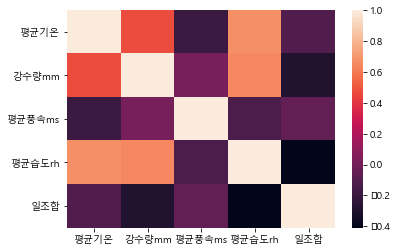

In [31]:
sns.heatmap(weather_retail_data.corr())

# sns.heatmap(weather_retail_data[weather_retail_data.columns.difference(['일시'])])

백화점


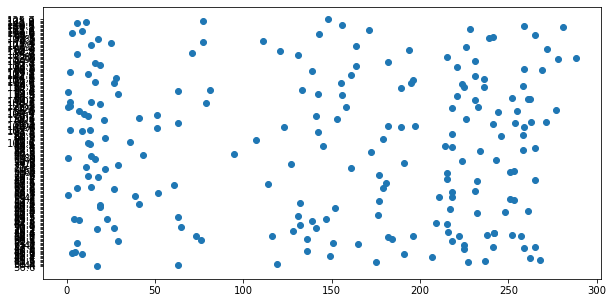

편의점


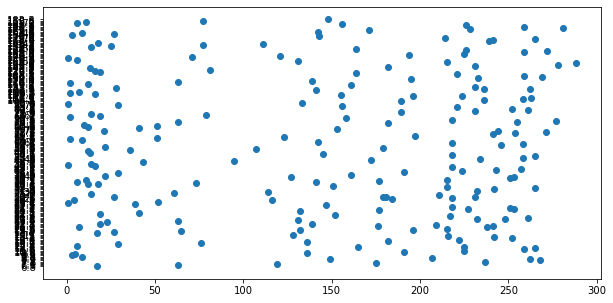

인터넷쇼핑


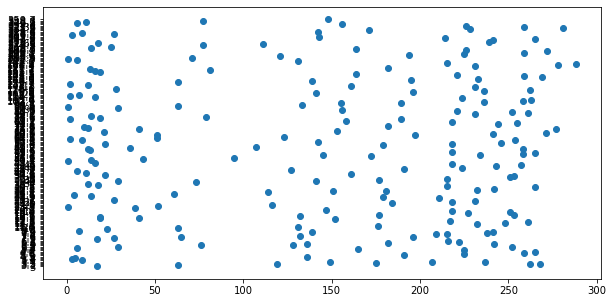

In [41]:
for i, retail in enumerate(retails_columns):
    print(retail)
    plt.figure(figsize=(10,5))
    plt.scatter(weather_retail_data['평균기온'], weather_retail_data[retail])
    plt.show()

백화점


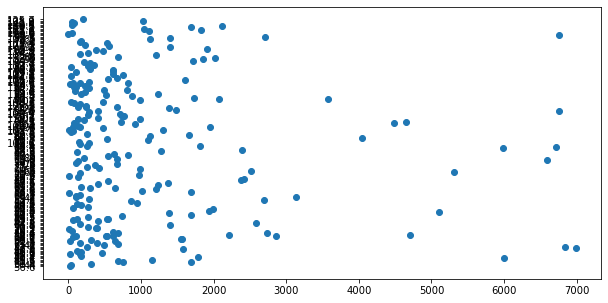

편의점


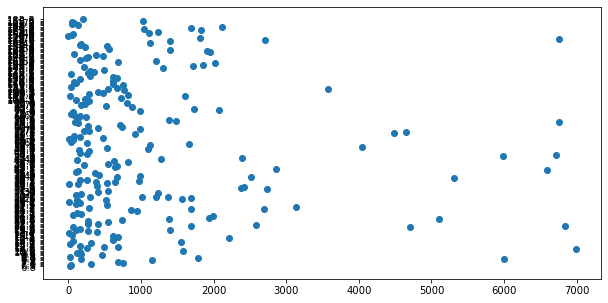

인터넷쇼핑


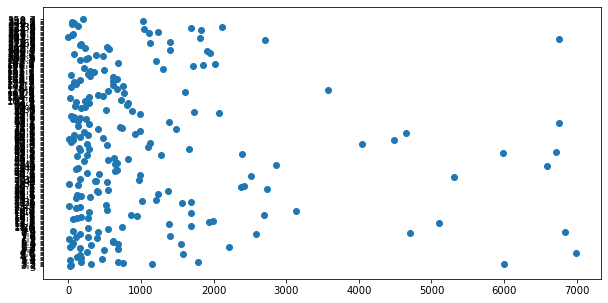

In [42]:
for i, retail in enumerate(retails_columns):
    print(retail)
    plt.figure(figsize=(10,5))
    plt.scatter(weather_retail_data['강수량mm'], weather_retail_data[retail])
    plt.show()

백화점


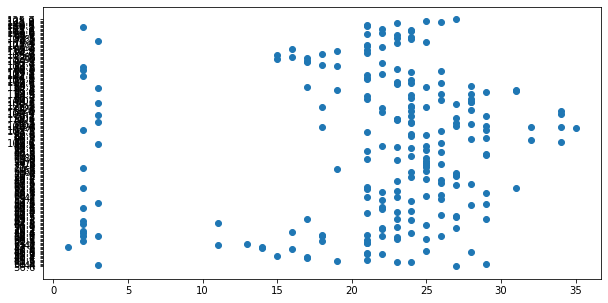

편의점


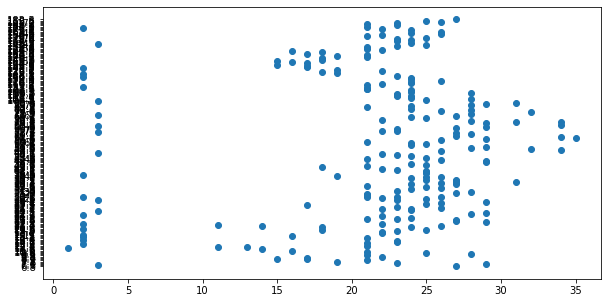

인터넷쇼핑


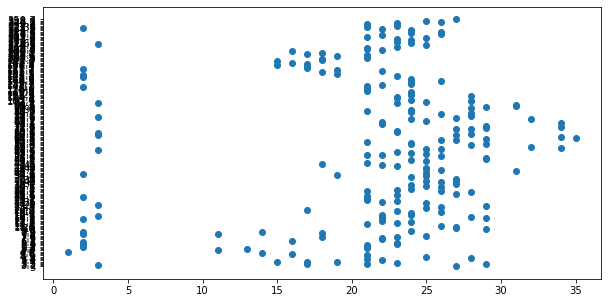

In [43]:
for i, retail in enumerate(retails_columns):
    print(retail)
    plt.figure(figsize=(10,5))
    plt.scatter(weather_retail_data['평균풍속ms'], weather_retail_data[retail])
    plt.show()



백화점


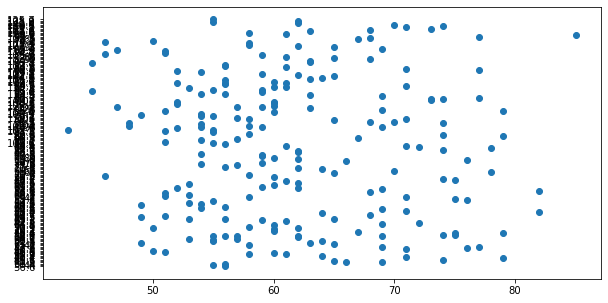

편의점


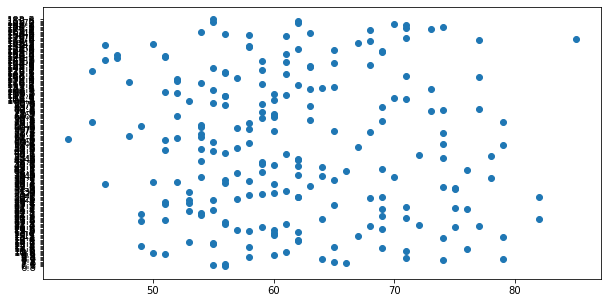

인터넷쇼핑


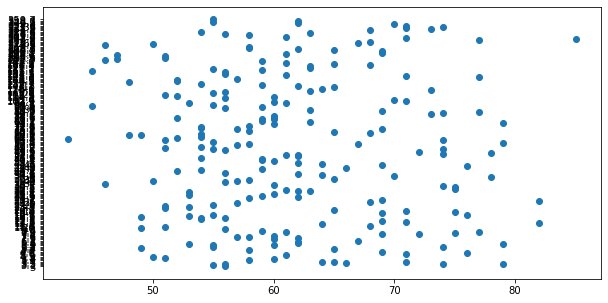

In [44]:
for i, retail in enumerate(retails_columns):
    print(retail)
    plt.figure(figsize=(10,5))
    plt.scatter(weather_retail_data['평균습도rh'], weather_retail_data[retail])
    plt.show()

백화점


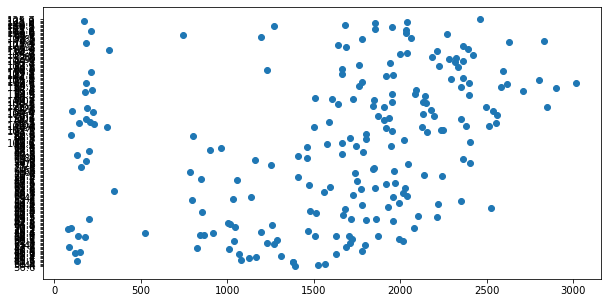

편의점


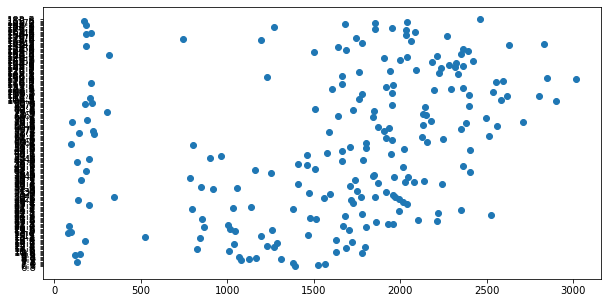

인터넷쇼핑


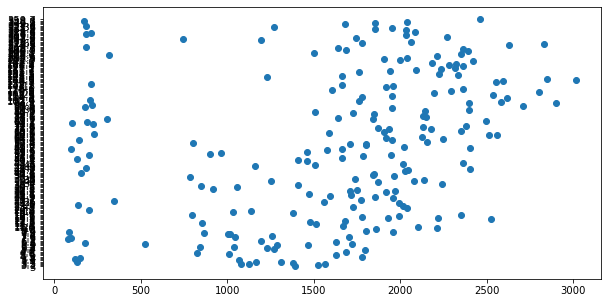

In [45]:
for i, retail in enumerate(retails_columns):
    print(retail)
    plt.figure(figsize=(10,5))
    plt.scatter(weather_retail_data['일조합'], weather_retail_data[retail])
    plt.show()
